# 画像分類時の前処理まとめ

## 1. 前処理

### Mean Subtraction

入力画像から平均を引く。各ピクセルから引く。<br>

VGG で採用されている。

https://arxiv.org/pdf/1409.1556.pdf<br>
VGG：2.1 ARCHITECTURE  から抜粋<br>
During training, the input to our ConvNets is a fixed-size 224 × 224 RGB image. <br>
The only preprocessing we do is **subtracting the mean RGB value**, computed on the training set, 
from each pixel.The image is passed through a stack of convolutional (conv.) layers, 
where we use filters with a very small receptive field: 3 × 3 (which is the smallest size to capture the notion of left/right, up/down,center). 

### Per-pixel Mean Subtraction

入力画像から平均を引く。ピクセル・チャンネルごとに計算された平均を引く。<br>
即ち、224x224x3 個の値について個別に平均を計算し用いる。<br>

AlexNet、ResNet で採用されている

https://arxiv.org/pdf/1512.03385.pdf<br>
ResNet：3.4. Implementation から抜粋<br>
A 224×224 crop is randomly sampled from an image or its horizontal flip, <br>
**with the per-pixel mean subtracted** [21]. The standard color augmentation in [21] is used. 



## 2. Data Augmentation

<img src="15_imgnet/img400.png" width="350px" height="350px">

### (1) Horizontal Flip

画像をランダムに水平方向に反転する。

ImageNet では縦方向はなく水平方向の flip のみが使われる<br>
AlexNet 論文以降必ず使われている模様

### (2) Random Crop

画像をランダムにトリミングする<br>

AlexNet で採用<br>
- 256x256 ピクセルに画像をリサイズし、そこから 224x224 のパッチをランダムに取り出す

この手法の他に、回転なども合わせる。


### (3) Color Augmentation

<img src="15_imgnet/img401.png" width="350px" height="350px">

RGBの要素をランダムに変更する。

例 PCAによるノイズ発生手法<br>
各ピクセルの RGB を 3 次元のベクトルの集合だと考え PCA をかける。<br>
ガウス分布でノイズを生成し、固有ベクトル方向にノイズを加える。<br>
乱数は各ピクセルではなくパッチ全体に対して共通。

AlexNet で採用<br>
論文によると AlexNet の精度への寄与は 1% 程度。<br>
ResNet 本家論文でも使われている。

実際には、R、G、Bの値はある確率分布から引き出される。

そして、これは太陽光が少し黄色だったり、目標のイルミネーションが少し黄色であれば、<br>
画像の色は簡単に変わるかもしれませんが、物体やラベルは同じまま。

これらの色の歪みを導入したり、カラーシフトを導入したりすることで、画像の色の変化に<br>
合わせて学習アルゴリズムを強化可能

色の歪みを実装する方法の1つに、主成分分析：PCAを利用する。(PCA Color Augmentationと呼ばれる)<br>
詳細は実際にはAlexNetの論文参照。

例<br>
画像が主に紫色で、主に赤と青の色合いがあり、緑色が非常に少ない場合は<br>
赤と青に多くを加減する。


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io,transform
%matplotlib inline

# Using six sample images.
imnames = ['./15_imgnet/altar.jpg',
                   './15_imgnet/angora_rabbit.jpg',
                   './15_imgnet/dog01.jpg',
                   './15_imgnet/elephant_01.jpg',
                   './15_imgnet/monkey01.jpg']

# Read collection of images with imread_collection
imlist = (io.imread_collection(imnames))

すべての画像を標準の256×256サイズに変換

In [2]:
for i in range(len(imlist)):
	# Using the skimage.transform function-- resize image (m x n x dim).
	m=transform.resize(imlist[i],(256,256,3), mode='reflect')

すべてのピクセルをデータポイントとして扱い、データポイントでPCAを計算します。

すべての画像からRGB値を含むこれらすべてのベクトルの配列を作成します。

m×n×3の画像行列をrgb値のリスト、すなわち（m * n）×3のリストに変換

In [3]:
# initializing with zeros.
res = np.zeros(shape=(1,3))

for i in range(len(imlist)):
	m=transform.resize(imlist[i],(256,256,3), mode='reflect')
	# Reshape the matrix to a list of rgb values.
	arr=m.reshape((256*256),3)
	# concatenate the vectors for every image with the existing list.
	res = np.concatenate((res,arr),axis=0)

# delete initial zeros' row
res = np.delete(res, (0), axis=0)
# print list of vectors - 3 columns (rgb)
print(res)

[[ 0.02020623  0.0286219   0.00937691]
 [ 0.09145412  0.0289321   0.02064568]
 [ 0.1082644   0.05765165  0.03424575]
 ..., 
 [ 0.29893362  0.26238337  0.24011009]
 [ 0.25895281  0.21581556  0.20012928]
 [ 0.27125235  0.2281151   0.20524439]]


PCAが正しく機能するには、各次元から平均を引く必要があります。

In [4]:
m = res.mean(axis = 0)
res = res - m
print(res)

[[-0.43509056 -0.3534053  -0.28928961]
 [-0.36384267 -0.3530951  -0.27802084]
 [-0.34703239 -0.32437555 -0.26442077]
 ..., 
 [-0.15636317 -0.11964383 -0.05855643]
 [-0.19634398 -0.16621165 -0.09853724]
 [-0.18404443 -0.15391211 -0.09342214]]


共分散行列の計算<br>
データは3次元なので、cov行列は3x3になります。

In [5]:
R = np.cov(res, rowvar=False)
print(R)

[[ 0.07346279  0.06692226  0.05789118]
 [ 0.06692226  0.06878919  0.06116043]
 [ 0.05789118  0.06116043  0.0594544 ]]


共分散行列の固有ベクトルと固有値を計算

幾何学的には、実際の非ゼロ固有値に対応する**固有ベクトルは、<br>
変換によって引き伸ばされた方向**を指し、<br>
**固有値は、それが引き伸ばされるファクタ**です。<br>
固有値が負の場合、方向は逆になります。

今、最高値を持つ固有ベクトルもデータセットの主成分です。<br>
たとえば、データがX軸に最も広がっている場合は、x軸を表す固有ベクトルが主成分です。

固有ベクトルが見つかると、それらを最高から最低までソートします。<br>
情報の損失が小さくなるので、今度はより低い固有値を無視することができる。

このようにして、いくつかのコンポーネントを残しておけば、最終データは<br>
元のデータセットよりも少ないコンポーネントになります。


In [6]:
from numpy import linalg as LA
evals, evecs = LA.eigh(R)
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]

# sort eigenvectors according to same index
evals = evals[idx]

# select the best 3 eigenvectors (3 is desired dimension
# of rescaled data array)
evecs = evecs[:, :3]

# make a matrix with the three eigenvectors as its columns.
evecs_mat = np.column_stack((evecs))

固有ベクトルまたはデータ内に保持したい成分を選択して特徴ベクトルを作成すると、<br>
ベクトルの転置を取り、転置された元のデータセットの左にそれを掛けます。<br>
-> この行列の数学を解くことができます!

In [7]:
# carry out the transformation on the data using eigenvectors
# and return the re-scaled data, eigenvalues, and eigenvectors
m = np.dot(evecs.T, res.T).T

これでデータ間の関係を最もよく描写する線であるパターンの観点から<br>
表現するようにデータを変換しました。

固有値による変換の場合、これらの固有ベクトルの大きさまたは「ストレッチのレベル」（視覚的に）<br>
を方向を変えずに単純に変更しました。

さて、画素値に対してPCAを実行した後、見つかった主成分の倍数に、<br>
対応する固有値に比例する大きさを加え、<br>
平均値ゼロおよび標準偏差0.1のガウス分布から引かれた確率変数を乗算する<br>
必要があります。 

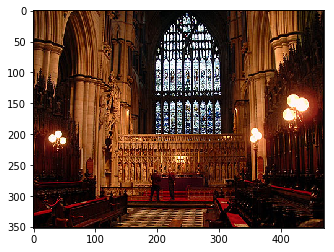

In [8]:
def data_aug(img):
	mu = 0
	sigma = 0.1
	feature_vec=np.matrix(evecs_mat)

	# 3 x 1 scaled eigenvalue matrix
	se = np.zeros((3,1))
	se[0][0] = np.random.normal(mu, sigma)*evals[0]
	se[1][0] = np.random.normal(mu, sigma)*evals[1]
	se[2][0] = np.random.normal(mu, sigma)*evals[2]
	se = np.matrix(se)
	val = feature_vec*se

	# Parse through every pixel value.
	for i in range(img.shape[0]):
		for j in range(img.shape[1]):
			# Parse through every dimension.
			for k in range(img.shape[2]):
				img[i,j,k] = float(img[i,j,k]) + float(val[k])

	return img

# Calling function for first image.
# Re-scaling from 0-255 to 0-1.
img0 = imlist[0]
img1 = img0/255.0
img1_aug = data_aug(img=img1)

plt.imshow(img0)

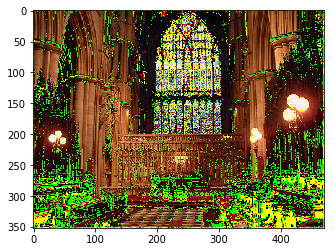

In [9]:
plt.imshow(img1_aug)

### (4) Scale Augmentation

まず画像をリサイズする。[256, 480] からランダムに短辺の長さを選ぶ。<br>
次に、224x224 のパッチをそこからランダムサンプルする。

VGG 論文から採用、ResNet 本家論文でも採用

### (5) Aspect Ratio Augmentation

上の Scale Augmentation(画像リサイズ) に加え画像のアスペクト比を [3/4, 4/3] で変換する

GoogLeNet の論文で使われている。

## 3. テスト時

### Ensemble

複数のモデルを独立に学習し、それらの予測を平均する。

GoogLeNet 論文では、ネットワークは同じだが入力の処理法を変えた 7 つのモデルを<br>
アンサンブルしている。<br>
single crop だと top-5 error が 2% 弱程度向上。

ResNet 本家論文では、34B, 34C, 50, 101, 152×2 の 6 モデルをアンサンブルしている。<br>
fully-convolutional-form で top-5 error に 1% 弱程度向上。

### 10-crop Testing

テスト画像 1 つから data augmentation と類似した手順で 10 個のパッチを切り出し、<br>
それぞれに対する予測を平均して答える。

AlexNet 論文では、（4 スミ＋中央）×（反転の有無）で 10 個のパッチを切り出している。<br>
GoogLeNet は 144 パッチも試してる。<br>
ResNet でも採用している。

GoogLeNet 論文では、crop 数の精度への影響が載っている。<br>
top-5 error で、10 crops で約 1% 弱向上、<br>
144 crops で 2% 強向上（下表は GoogLeNet 論文より引用）。

<img src="https://cdn-ak.f.st-hatena.com/images/fotolife/i/iwiwi/20161231/20161231213228.png"
width="380px" height="380px">

### Fully-convolutional-form Testing

まず、全結合層たちを畳み込み層とみなす。

例えば、直前の画像サイズが s×s であれば、最初の全結合層は s×s → 1×1 の畳み込み層であるとみなす。<br>
すると、ネットワークは全レイヤーが畳み込みとなる。fully convolutional なネットワークの利点は、<br>
入力の画像サイズが変化しても適用することができることである（ただし、出力サイズも変化する）。

テスト画像をリサイズする。この時の画像サイズは、学習で使っている画像サイズと一致しているとは限らないし、
正方形とも限らない。

例えば、短辺を 480 にする。ネットワークをこの画像に適用する。出力を average pooling してそれを予測とする。

さらに、テスト画像のサイズを複数試し、その結果の平均を用いる。

例えば、ResNet 本家論文では短辺を 224, 256, 384, 480, 640 になるようにリサイズしている。<br>
また、horizontal flip も試して平均を取る。

VGG から使われている。<br>
ResNet 本家論文を見るところ、10-crop Testing と比べて、大体 2% 程度精度に寄与している。

## 参考文献

[1] VGG‒Net (2014)<br>
Very Deep Convolutional Networks for Large‒Scale Visual Recognition. arXiv: 1409.1556, 2014. <br>
https://arxiv.org/pdf/1409.1556.pdf

[2]GoogleNet(2014)<br>
Going deeper with convolutions. arXiv: 1409.4842, 2014. <br>
https://arxiv.org/pdf/1409.4842.pdf

[3]ResNet(2015)<br>
Deep Residual Learning for Image Recognition. arXiv:1512.03385, 2015.<br>
https://arxiv.org/pdf/1512.03385.pdf

[4]CNN による画像分類で使われる前処理・テスト時処理まとめ<br>
http://iwiwi.hatenadiary.jp/entry/2016/12/31/162059

[5]画像の水増し方法をTensorFlowのコードから学ぶ<br>
https://qiita.com/Hironsan/items/e20d0c01c95cb2e08b94

[6]Fancy PCA (Data Augmentation) with Scikit-Image<br>
https://deshanadesai.github.io/notes/Fancy-PCA-with-Scikit-Image

[7]【数学】固有値・固有ベクトルとは何かを可視化してみる<br>
https://qiita.com/kenmatsu4/items/2a8573e3c878fc2da306